In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/trashnet


In [2]:
import os

dataset_path = os.path.join(path, 'dataset-resized')

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import pickle

with open('/content/drive/MyDrive/TrashNetProject/process_data/classes.pkl', 'rb') as f:
    classes = pickle.load(f)
print("Classes:", classes)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

IMG_SIZE= (64,64)

# Function to load and preprocess images
def load_images(dataset_path, classes, img_size):
    images = []
    labels = []
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(img_size)
            img_array = np.array(img) / 127.5 - 1.0  # Normalize to [-1, 1]
            images.append(img_array)
            labels.append(class_idx)  # Integer label
    return np.array(images), np.array(labels)

real_images, real_labels = load_images(dataset_path, classes, IMG_SIZE)

# One-hot encode labels for conditioning
num_classes = len(classes)
real_labels_onehot = tf.keras.utils.to_categorical(real_labels, num_classes)

# Create TensorFlow dataset
BUFFER_SIZE = len(real_images)  # Shuffle buffer
BATCH_SIZE = 32  # Adjust based on your GPU memory (start small)

dataset = tf.data.Dataset.from_tensor_slices((real_images, real_labels_onehot))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Loaded {len(real_images)} images with shape {real_images.shape}")

Loaded 2527 images with shape (2527, 64, 64, 3)


In [8]:
LATENT_DIM = 100  # Size of noise vector

def build_generator(latent_dim, num_classes, img_shape):
    # Label input
    label_input = layers.Input(shape=(num_classes,))
    # Embed label to a dense vector
    label_embedding = layers.Dense(128)(label_input)

    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    # Combine noise + label
    combined = layers.Concatenate()([noise_input, label_embedding])

    # Dense layer to start upsampling
    x = layers.Dense(8 * 8 * 256)(combined)  # For 128x128, adjust based on img_size (e.g., start from 4x4 or 8x8 grid)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Upsample to 16x16
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Upsample to 64x64
    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)  # Output [-1,1]

    model = models.Model([noise_input, label_input], x)
    return model

generator = build_generator(LATENT_DIM, num_classes, IMG_SIZE + (3,))
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 228)       │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16384)     │  3,751,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 8, 256) │      1,024 │ reshape[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,416 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    131,136 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64, 3) │      3,075 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,413,251 (16.84 MB)

 Trainable params: 4,412,355 (16.83 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
def build_discriminator(img_shape, num_classes):
    # Image input
    img_input = layers.Input(shape=img_shape)

    # Label input
    label_input = layers.Input(shape=(num_classes,))
    # Embed label and reshape to match image dimensions (for concatenation)
    label_embedding = layers.Dense(img_shape[0] * img_shape[1])(label_input)
    label_embedding = layers.Reshape((img_shape[0], img_shape[1], 1))(label_embedding)

    # Concatenate label with image
    combined = layers.Concatenate()([img_input, label_embedding])

    # Downsample
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(combined)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Real/fake probability

    model = models.Model([img_input, label_input], output)
    return model

discriminator = build_discriminator(IMG_SIZE + (3,), num_classes)
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4096)      │     28,672 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64, 4) │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      4,160 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    524,544 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16384)     │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     16,385 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 706,497 (2.70 MB)

 Trainable params: 705,729 (2.69 MB)

 Non-trainable params: 768 (3.00 KB)

In [10]:
# Optimizers
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Compile discriminator (trainable)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Freeze discriminator for GAN training
discriminator.trainable = False

# Combined GAN model: noise + label -> generator -> discriminator
noise_input = layers.Input(shape=(LATENT_DIM,))
label_input = layers.Input(shape=(num_classes,))
generated_img = generator([noise_input, label_input])
validity = discriminator([generated_img, label_input])

gan = models.Model([noise_input, label_input], validity)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64, 64, 3) │  4,413,251 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 1)         │    706,497 │ functional[0][0], │
│ (Functional)        │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,119,748 (19.53 MB)

 Trainable params: 4,412,355 (16.83 MB)

 Non-trainable params: 707,393 (2.70 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

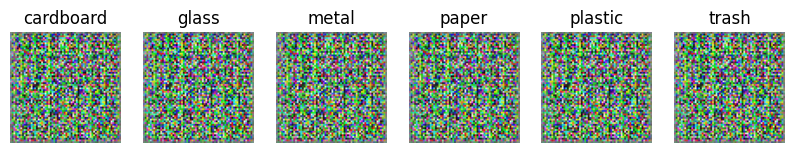

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

<Figure size 640x480 with 0 Axes>

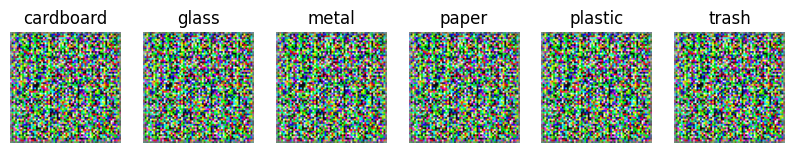

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

<Figure size 640x480 with 0 Axes>

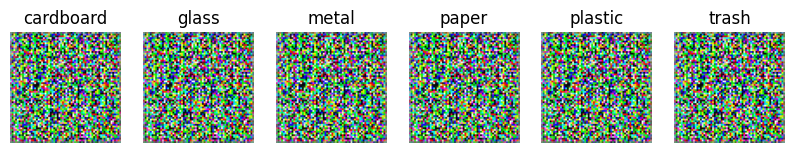

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

<Figure size 640x480 with 0 Axes>

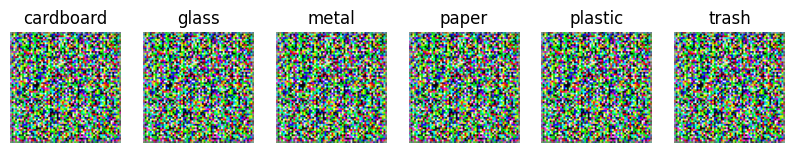

<Figure size 640x480 with 0 Axes>

In [11]:
EPOCHS = 20  # Increase to 50-100 for better results; monitor for mode collapse
noise_dim = LATENT_DIM

# Labels for real (1) and fake (0)
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    for batch_imgs, batch_labels in dataset:
        # Train Discriminator
        # Generate fake images
        noise = np.random.normal(0, 1, (len(batch_imgs), noise_dim))
        gen_imgs = generator.predict([noise, batch_labels])

        # Train on real
        d_loss_real = discriminator.train_on_batch([batch_imgs, batch_labels], real[:len(batch_imgs)])
        # Train on fake
        d_loss_fake = discriminator.train_on_batch([gen_imgs, batch_labels], fake[:len(batch_imgs)])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, noise_dim))
        sampled_labels = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, BATCH_SIZE), num_classes)
        g_loss = gan.train_on_batch([noise, sampled_labels], real)

    print(f"Epoch {epoch+1}/{EPOCHS} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

    # Save sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        noise = np.random.normal(0, 1, (num_classes, noise_dim))
        labels = tf.keras.utils.to_categorical(np.arange(num_classes), num_classes)
        gen_samples = generator.predict([noise, labels])
        # Denormalize for display: ([-1,1] -> [0,1])
        gen_samples = 0.5 * gen_samples + 0.5

        plt.figure(figsize=(10, 5))
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            plt.imshow(gen_samples[i])
            plt.title(classes[i])
            plt.axis('off')
        plt.show()
        plt.savefig(f"gan_samples_epoch_{epoch+1}.png")

# Save models after training
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

In [12]:
# Generate 100 synthetic images per class
SYNTHETIC_PER_CLASS = 100
aug_images = []
aug_labels = []

for class_idx, class_name in enumerate(classes):
    noise = np.random.normal(0, 1, (SYNTHETIC_PER_CLASS, LATENT_DIM))
    labels = tf.keras.utils.to_categorical(np.full(SYNTHETIC_PER_CLASS, class_idx), num_classes)
    gen_batch = generator.predict([noise, labels])
    gen_batch = 0.5 * gen_batch + 0.5  # Denormalize to [0,1] for saving

    aug_images.extend(gen_batch)
    aug_labels.extend([class_idx] * SYNTHETIC_PER_CLASS)

    # Save to disk (optional)
    aug_dir = os.path.join("augmented_dataset", class_name)
    os.makedirs(aug_dir, exist_ok=True)
    for i, img in enumerate(gen_batch):
        plt.imsave(os.path.join(aug_dir, f"synthetic_{i}.jpg"), img)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Here's a review of your notebook for generating synthetic waste images using GANs:

**Current state of the notebook:**

*   You have successfully loaded the TrashNet dataset and defined the image loading and preprocessing function.
*   You have defined and summarized the generator and discriminator models for your Conditional GAN (CGAN).
*   You have compiled both the discriminator and the combined GAN model with appropriate optimizers and loss functions.

**Suggestions for improvement and next steps:**

1.  **Refine Model Architectures:** While your current models are a good starting point, consider experimenting with different architectures or adding more layers to potentially improve the quality of generated images. Techniques like using more advanced convolutional layers or incorporating attention mechanisms could be explored.
2.  **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, and the number of epochs. GAN training is notoriously sensitive to hyperparameters.
3.  **Conditional Input in Discriminator:** You have included the class labels as input to the discriminator, which is correct for a Conditional GAN. Ensure that the label embedding is effectively combined with the image features in the discriminator's architecture.
4.  **Training Stability:** GAN training can be unstable. If you encounter issues like mode collapse (the generator only producing a limited variety of images), consider techniques like:
    *   Using different loss functions (e.g., Wasserstein GAN with Gradient Penalty - WGAN-GP).
    *   Implementing a history of generated images for the discriminator.
    *   Adjusting the balance between generator and discriminator training.
5.  **Evaluation Metrics:** Besides visual inspection, consider using quantitative metrics to evaluate the quality and diversity of generated images, such as:
    *   Inception Score (IS)
    *   Frechet Inception Distance (FID)
    *   Structural Similarity Index (SSIM)
6.  **Augmentation Strategy:** Once you are satisfied with the quality of the generated images, you can integrate them with your real dataset. Consider different strategies for augmenting your dataset, such as adding a certain percentage of synthetic images per class.
7.  **Downstream Task Evaluation:** The ultimate goal is to improve the performance of a downstream task (e.g., waste classification). Train and evaluate your classification model on the augmented dataset to see if the synthetic images are beneficial.

Overall, your notebook is well-structured and you've made good progress. The next steps involve refining the models, tuning hyperparameters, and focusing on training stability and evaluation.

# Task
Refine the GAN model in the provided notebook for generating synthetic waste images to improve image quality and diversity, and evaluate its impact on a downstream classification task.

## Refine generator architecture

### Subtask:
Modify the generator model to potentially improve image quality. This might involve adding more layers, changing filter sizes, or using different activation functions.


**Reasoning**:
The goal is to modify the generator architecture to potentially improve image quality. I will add an additional upsampling layer and increase the number of filters in some layers. I will also change the activation functions to 'relu' in the intermediate layers, keeping 'tanh' for the output.



In [ ]:
def build_generator(latent_dim, num_classes, img_shape):
    # Label input
    label_input = layers.Input(shape=(num_classes,))
    # Embed label to a dense vector
    label_embedding = layers.Dense(256)(label_input) # Increased dense size

    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    # Combine noise + label
    combined = layers.Concatenate()([noise_input, label_embedding])

    # Dense layer to start upsampling
    x = layers.Dense(4 * 4 * 512)(combined)  # Adjusted based on img_size, increased filters
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # Changed activation

    # Upsample to 8x8
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x) # Increased filters
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # Changed activation

    # Upsample to 16x16
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x) # Increased filters
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # Changed activation

    # Upsample to 32x32
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) # Changed activation

    # Upsample to 64x64
    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)  # Output [-1,1]

    model = models.Model([noise_input, label_input], x)
    return model

generator = build_generator(LATENT_DIM, num_classes, IMG_SIZE + (3,))
generator.summary()

**Reasoning**:
The generator model architecture has been modified. Now I need to update the combined GAN model with the new generator and display its summary to ensure the changes are reflected correctly before proceeding with training.



**Reasoning**:
The generator and GAN models have been successfully updated with the refined architecture. The next step is to run the training loop again with the updated models to see if the changes improve the generated image quality.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
